# EXERCISE 7.1: Land-Use-Land-Cover Pipeline - Experiment Tracking

---

**Use of Google Earth Engine with Rwandan geodata to train a LULC classifier using various algorithms available in scikitlearn in a systematized experiment tracking environment employing WandB**

In this repeat of exercise 6.1, we will use wandb to demonstrate experiment tracking.

For your convienience, we will keep some of the instructions from the previous exercise.

But first you have to create a Wandb account.

1. Sign up for a free account at https://wandb.ai/site and then login to your wandb account.
2. Install the wandb library on your machine in a Python 3 environment using pip as shown below.

In [ ]:
!pip install wandb -qqq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 52.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.3/203.3 kB 21.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.0 MB/s eta 0:00:00


Install the packages needed for 6.1

In [ ]:
!pip install geemap -qqq


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 59.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 76.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 65.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 41.6 MB/s eta 0:00:00


## Setup
If you have already run this setup (for e.g as part of Exercise 5_02), please reuse the private key.
Otherwise, follow the steps at https://docs.google.com/document/d/13SKLn_mqhlaRc1gElr4kmBrkw6KZPeqDDW3AjcTr8YY/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import wandb and other required packages.

In [ ]:
import wandb
import ee
import time
import sys
import numpy as np
import pandas as pd
import itertools
import os
import traceback
import urllib
import folium

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from oauth2client.service_account import ServiceAccountCredentials

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
import seaborn as sns
import geemap
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from scipy.stats import uniform

Next, use the W&B Python SDK and log in:
- Provide your API key when prompted.
- To get your API key go to https://wandb.ai/authorize
- Copy the API key displayed to your screen and paste it to the prompt.

In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Setup Your Google Earth Engine Credentials
Upload the `.private-key.json` you created while setting up GEE to the current runtime. Click Files > Upload to Session storage on the left pane in this notebook to upload. <br/>
Replace the service account in the code below with your Google Cloud project service account email. It should be of the format <br/>`<id>@ml4eo-<some_number>.iam.gserviceaccount.com`

In [ ]:
service_account = 'ml4eo-service@ml4eo-383508.iam.gserviceaccount.com'
credentials = ee.ServiceAccountCredentials(service_account, '.private-key.json')
ee.Initialize(credentials)

Now let's load the following helper function to be used later in the script

In [ ]:
def Mapdisplay(center, dicc, Tiles="OpensTreetMap",zoom_start=10):
    '''
    :param center: Center of the map (Latitude and Longitude).
    :param dicc: Earth Engine Geometries or Tiles dictionary
    :param Tiles: Mapbox Bright,Mapbox Control Room,Stamen Terrain,Stamen Toner,stamenwatercolor,cartodbpositron.
    :zoom_start: Initial zoom level for the map.
    :return: A folium.Map object.
    '''
    mapViz = folium.Map(location=center,tiles=Tiles, zoom_start=zoom_start)
    for k,v in dicc.items():
      if ee.image.Image in [type(x) for x in v.values()]:
        folium.TileLayer(
            tiles = v["tile_fetcher"].url_format,
            attr  = 'Google Earth Engine',
            overlay =True,
            name  = k
          ).add_to(mapViz)
      else:
        folium.GeoJson(
        data = v,
        name = k
          ).add_to(mapViz)
    mapViz.add_child(folium.LayerControl())
    return mapViz

### Getting the Training data


In [ ]:
# Remember this function from Exercise 5_03, what does it do?
def se2mask(image):
    quality_band = image.select('QA60')
    cloudmask = 1 << 10
    cirrusmask = 1 << 11
    mask = quality_band.bitwiseAnd(cloudmask).eq(0) and (quality_band.bitwiseAnd(cirrusmask).eq(0))
    return image.updateMask(mask).divide(10000)

In [ ]:
lat = -1.9441
lon = 30.0619
offset = 0.51
region = [
        [lon + offset, lat - offset],
        [lon + offset, lat + offset],
        [lon - offset, lat + offset],
        [lon - offset, lat - offset]]


To ensure all our hyperparameters are tracked by Wandb lets create a dictionary called `config` that contains all our hyperparameters and settings.


In [ ]:
config = {
    'region': region,
    'se2bands': ['B2', 'B3', 'B4', 'B5', 'B6', 'B7','B8','B8A'],
    'trainingbands': ['B2', 'B3', 'B4', 'B5', 'B6', 'B7','B8','B8A', 'avg_rad'],
    'label': 'smod_code',
    'scaleFactor': 1000,
    's2_start_date': "2015-07-01",
    's2_end_date': "2015-12-31",
    'cloudy_pixel_percentage': 20,
    'viirs_start_date': "2015-07-01",
    'viirs_end_date': "2015-12-31",
    'ghsl_start_date': '2015-01-01',
    'ghsl_end_date': '2015-12-31',
    'sample_geometries': True,
    'sample_seed': 0,
    'split_thresh': 0.8,
    'split_seed': 0,
    "numberOfTrees":100,
    "variablesPerSplit":None,
    "minLeafPopulation":1,
    "bagFraction":0.5,
    "maxNodes":None,
    "rf_seed":42,
    "normalizeData": False,
}

Once the config file

In [ ]:
roi = ee.Geometry.Polygon([config['region']])

# Initialize Wandb

In [ ]:
wandb.init(project='GEE_7_1', config=config)

wandb: Currently logged in as: abrsh (ane). Use `wandb login --relogin` to force relogin


In [ ]:
se2bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7','B8','B8A']
trainingbands = se2bands + ['avg_rad']
label = 'smod_code'
scaleFactor=1000

se2 = ee.ImageCollection('COPERNICUS/S2').filterDate(
    config['s2_start_date'], config['s2_end_date'])

# TODO: Use the filterBounds function to get filter the are specified in ROI
se2 = se2.filterBounds(roi)

# Keep pixels that have less than 20% cloud
se2 = se2.filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", config['cloudy_pixel_percentage']))

# Update the mask
se2 = se2.map(se2mask)

# Get the median image
se2 = se2.median()

se2 = se2.select(config['se2bands'])

viirs = ee.Image(ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG").filterDate(
    config['viirs_start_date'], config['viirs_end_date']).filterBounds(roi).median().select('avg_rad').clip(roi))
if config['normalizeData']:
    vmu = viirs.reduceRegion(reducer=ee.Reducer.mean(),scale=scaleFactor)
    vstd = viirs.reduceRegion(reducer=ee.Reducer.stdDev(),scale=scaleFactor)

    vmu = ee.Number(vmu.get('avg_rad'))
    vstd = ee.Number(vstd.get('avg_rad'))

    # Whiten the band
    viirsclean = viirs.subtract(vmu).divide(vstd)
else:
    viirsclean = viirs
# TODO: Read https://developers.google.com/earth-engine/apidocs/ee-image-addbands
# Use the function above to fuse the se2 and viirs bands

fused = se2.addBands(viirs)

# Get the Labels from the GHSL Dataset

In [ ]:
ghsl = ee.ImageCollection('JRC/GHSL/P2016/SMOD_POP_GLOBE_V1').filter(ee.Filter.date(
    config['ghsl_start_date'], config['ghsl_end_date'])).select(config['label']).median().gte(2).clip(roi)

points = ghsl.sample(**{"region":roi, "scale":config['scaleFactor'],"seed":config['sample_seed'],'geometries':config['sample_geometries']})

In [ ]:
data = fused.select(config['trainingbands']).sampleRegions(collection=points,
                                                        properties=[config['label'],],
                                                        scale=config['scaleFactor'])

In [ ]:
data.aggregate_stats(config['label']).getInfo()


{'max': 1,
 'mean': 0.20737724175738115,
 'min': 0,
 'sample_sd': 0.4054439481595326,
 'sample_var': 0.16438479509918977,
 'sum': 2648,
 'sum_sq': 2648,
 'total_count': 12769,
 'total_sd': 0.4054280717445227,
 'total_var': 0.16437192135848186,
 'valid_count': 12769,
 'weight_sum': 12769,
 'weighted_sum': 2648}

### Train-test split
Now that we have gathered our data we would like to split the dataset into training and test sets. We first create a column of random numbers in the range [0, 1] and use that to split the data into training and test sets.

In [ ]:
# we'll create a column of random numbers
data = data.randomColumn(seed=config['split_seed'])

We will use a 80/20 train/test split randomly among the pixels in our 2015 training image

In [ ]:
split_thresh = config['split_thresh']
train = data.filter(ee.Filter.lt('random', split_thresh))
test = data.filter(ee.Filter.gte('random', split_thresh))


In [ ]:
train.aggregate_stats(config['label']).getInfo()

{'max': 1,
 'mean': 0.20640078778926638,
 'min': 0,
 'sample_sd': 0.40474144106332127,
 'sample_var': 0.16381563411401395,
 'sum': 2096,
 'sum_sq': 2096,
 'total_count': 10155,
 'total_sd': 0.40472151238751397,
 'total_var': 0.16379950258923662,
 'valid_count': 10155,
 'weight_sum': 10155,
 'weighted_sum': 2096}

In [ ]:
test.aggregate_stats(label).getInfo()

{'max': 1,
 'mean': 0.22092115534738485,
 'min': 0,
 'sample_sd': 0.4149484361173423,
 'sample_var': 0.1721822046362281,
 'sum': 566,
 'sum_sq': 566,
 'total_count': 2562,
 'total_sd': 0.4148674468638887,
 'total_var': 0.1721149984673615,
 'valid_count': 2562,
 'weight_sum': 2562,
 'weighted_sum': 566}

We have 10,252 observations (pixels) in our training set and 2,591 in our test set.

And notice balance of our label is similar for training and testing (~20.5% and ~20.5% classified as built-up, respectively), which we’d expect in a random split.



In [ ]:
init_params = {"numberOfTrees": config['numberOfTrees'],
              "variablesPerSplit": config["variablesPerSplit"],
              "minLeafPopulation": config["minLeafPopulation"],
              "bagFraction": config["bagFraction"],
              "maxNodes": config["maxNodes"],
              "seed": config["rf_seed"]
}

clf = ee.Classifier.smileRandomForest(**init_params).train(train, config['label'], config['trainingbands'])

## Saving Metrics and Values to Wandb
Wandb lets you log a dictionary of metrics, media, or custom objects to a step with the W&B Python SDK. W&B collects the key-value pairs during each step and stores them in one unified dictionary each time you log data with wandb.log(). Data logged from your script is saved locally to your machine in a directory called wandb, then synced to the W&B cloud or your private server.

First, let's get the metrics `oobErrorEstimate` and `feature_importance` from `clf.explain`.

In [ ]:
explanation = clf.explain().getInfo()
oobErrorEstimate = explanation['outOfBagErrorEstimate']
feature_importance = explanation['importance']

In [ ]:
wandb.log({'oobErrorEstimate': oobErrorEstimate, 'feature_importance': feature_importance})

## Go to Wandb
Now, go to [Wandb](https://wandb.ai/)

Once the page opens you will notice that there is a project named `GEE_7_1` on the left pane.
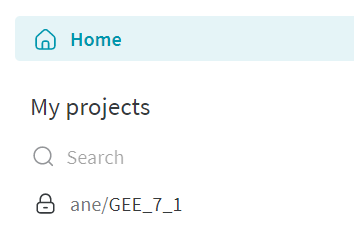

1. Click on the project and you will see something like below
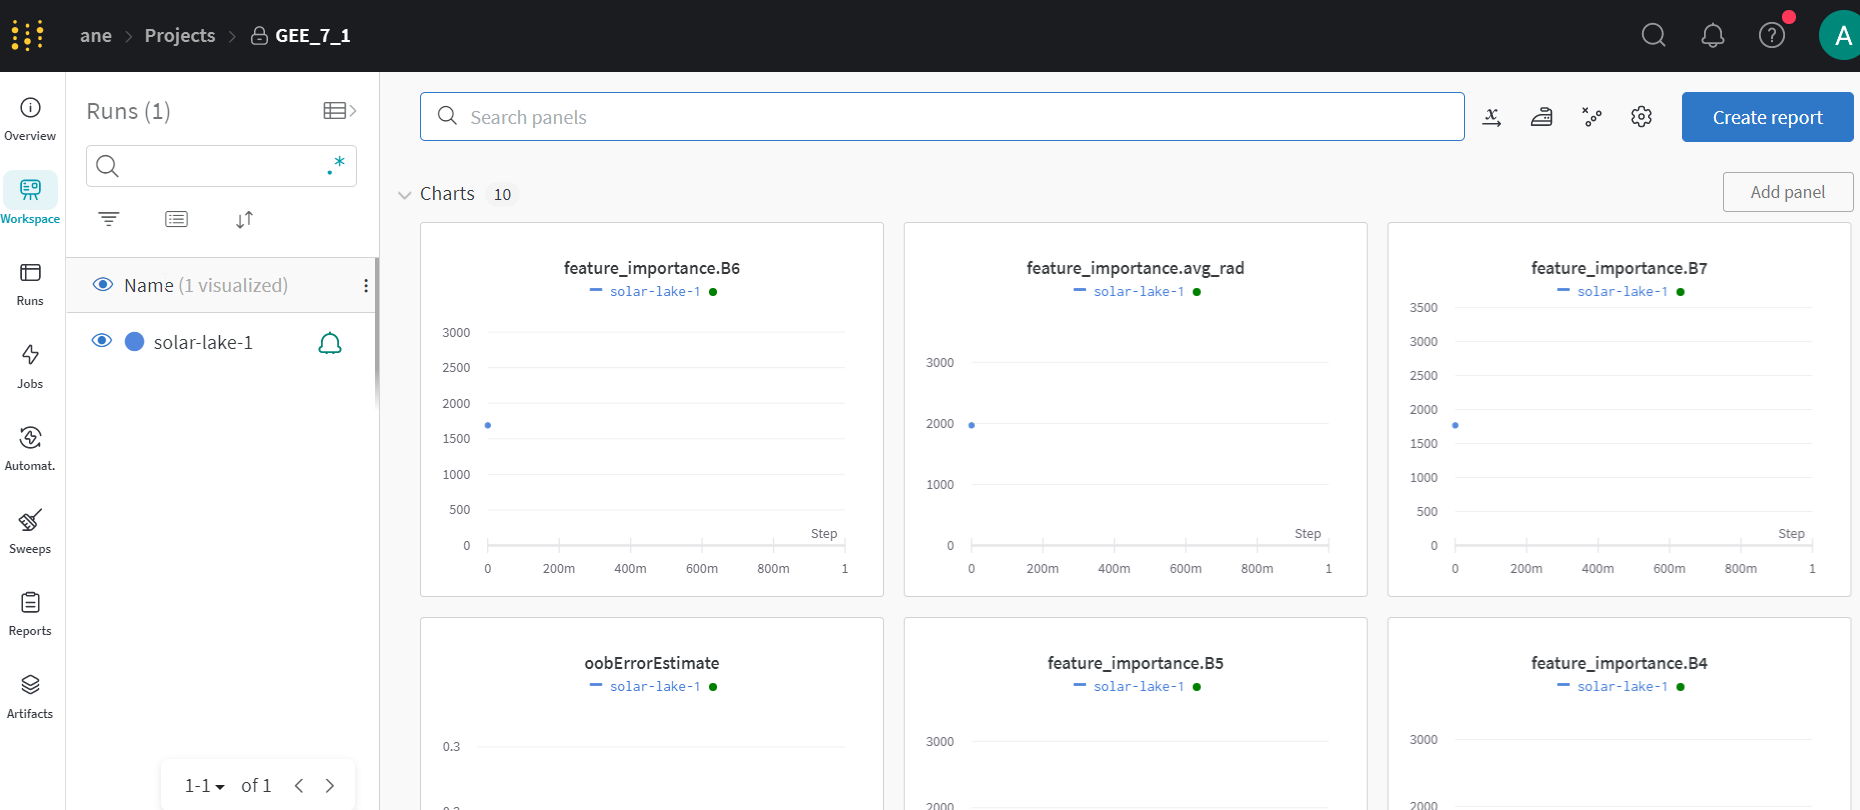

2. Click on the run (in my case `solar-lake-1`) to find
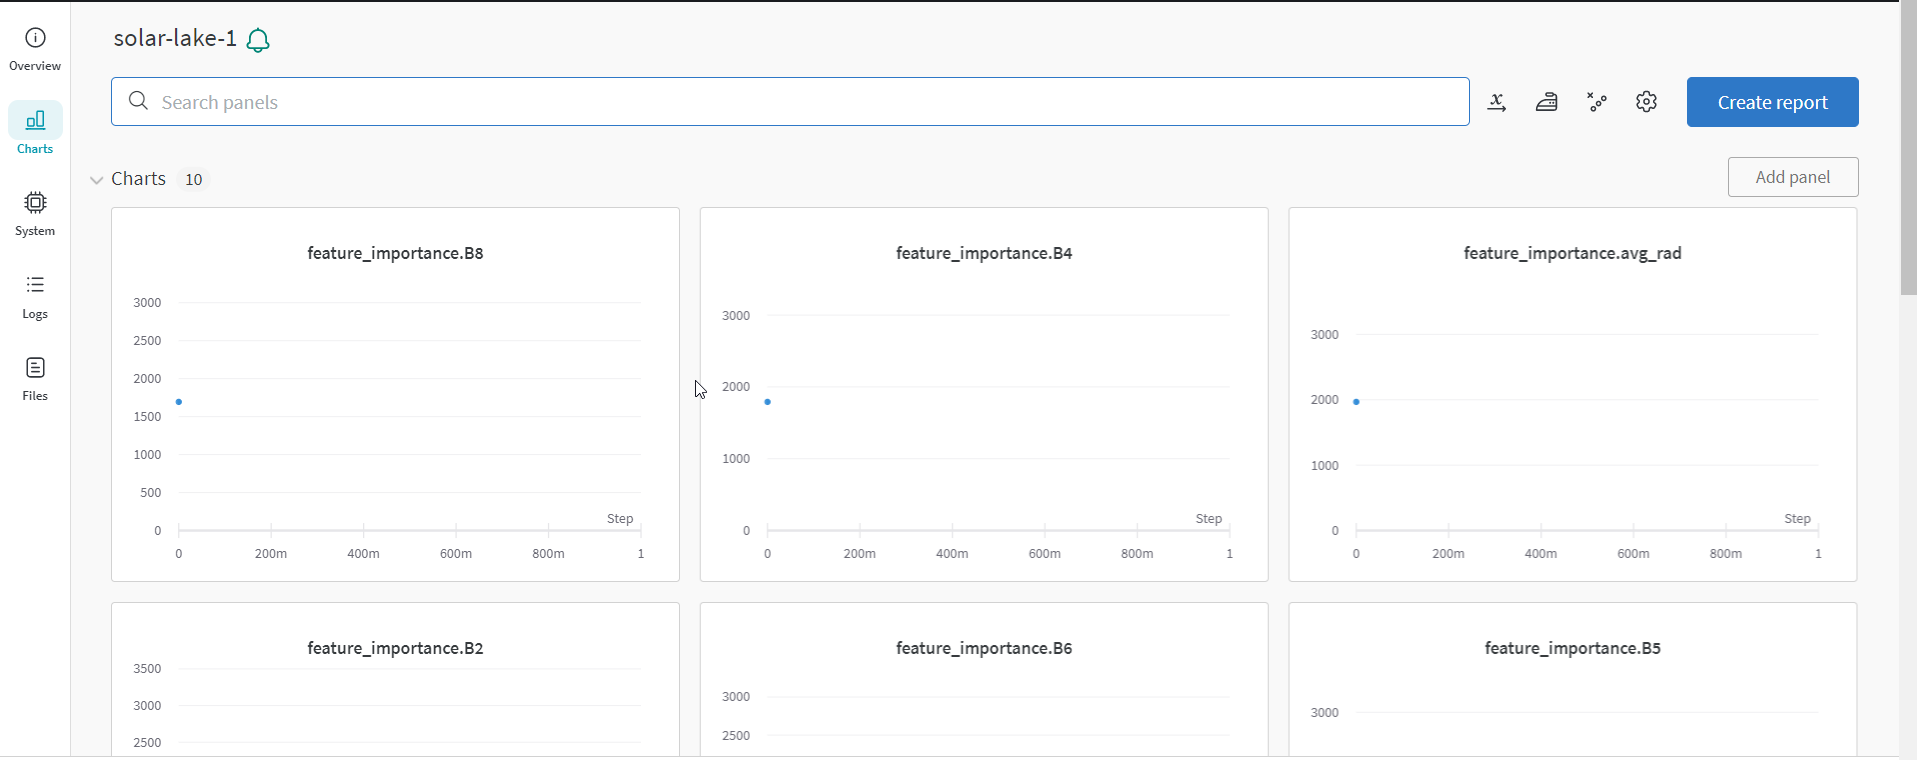

In the above figure, you can see all the metrics logged in different charts.

3. Click on `Overview` on the top left corner. If you scroll down, after the page opens you will see
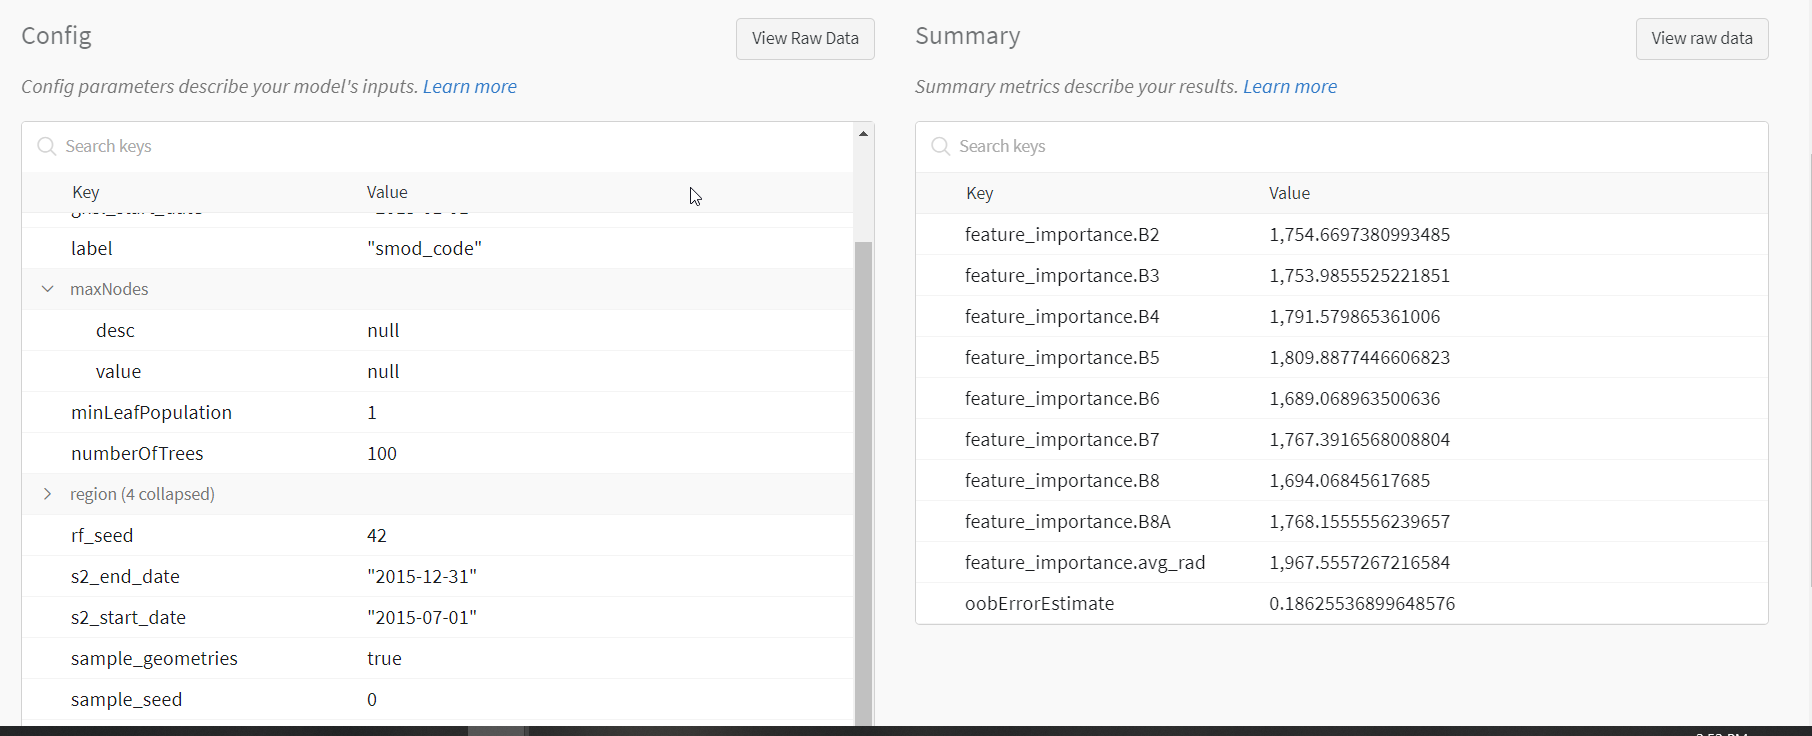

The values you see under Config are the configuration parameters while the values you see under summary are your logged metrics.

## Evaluation
We need metrics to determine how well the classifier performs. We just have a simple binary schema so we can visualize a confusion matrix, which shows the actual labels (y axis) and the predicted labels (x axis).

In [ ]:
trainResults = clf.confusionMatrix().getInfo()
trainCM = pd.DataFrame(np.asarray(trainResults), index=['not','built-up'], columns=['not','built-up'])

## Question 7.1.1
Log the confusion matrix

Now that our experiment is complete we may stop the Wandb logging by calling `wandb.finish`.

In [ ]:
wandb.finish()

oobErrorEstimate,▁
oobErrorEstimate,0.18785


## Question 7.1.2
Now go to the cell where `config` is defined and change `normalizeData` to `True` and rerun the training validation and logging.

## Training and Prediction outside Earth Engine
We have seen how to use Wandb to track GEE experiments. Wandb allows for a much more sophisticated experiment tracking when using libraries such as sklearn, and Pytorch.

Let's see how Wandb be can used with sklearn.

You can see that the type of `dataclean` is FeatureCollection. Let's now see how we can export the feature collection as CSV so we can use tools such as pandas to load the manipulate the data.

In [ ]:
def export_one_table(feature_collection, name):
  """Uses a GEE API to batch transfer data to a GCP project Google Drive"""
  task = ee.batch.Export.table.toDrive(**{
    'collection': feature_collection,
    'description': name,
    'fileFormat': 'CSV'
    })
  task.start()
  while task.active():
    print('Running...')
    # Wait for sometime before showing an update
    time.sleep(100)
  print('Done..', task.status())



In [ ]:
name = 'GEEToDrive'
export_one_table(data, name)

Running...
Done.. {'state': 'COMPLETED', 'description': 'GEEToDrive', 'creation_timestamp_ms': 1684054373976, 'update_timestamp_ms': 1684054393296, 'start_timestamp_ms': 1684054383210, 'task_type': 'EXPORT_FEATURES', 'destination_uris': ['https://drive.google.com/'], 'attempt': 1, 'batch_eecu_usage_seconds': 6.464535713195801, 'id': '2R65SCGBUB77XP5C44ZLGB5J', 'name': 'projects/earthengine-legacy/operations/2R65SCGBUB77XP5C44ZLGB5J'}


Move the CSV from service account Google Drive to a user user Google Drive.

In [ ]:
# Transfer the data from GCP service account drive to current working directory in Colaboratory
gauth = GoogleAuth()
scopes = ['https://www.googleapis.com/auth/drive']
gauth.credentials = ServiceAccountCredentials.from_json_keyfile_name(".private-key.json", scopes=scopes)

drive = GoogleDrive(gauth)

# get list of files
file_list = drive.ListFile({'q': "trashed=false"}).GetList()
print(f"{len(file_list)} files found")
for file_tiff in file_list:

        filename = file_tiff['title']
        if file_tiff['mimeType'] == 'text/csv':
          # download file into working directory (in this case a tiff-file)
          file_tiff.GetContentFile(filename, mimetype="image/tiff")

          # delete file afterwards to keep the Drive empty
          file_tiff.Delete()

222 files found


## Read the Downloaded CSV

Now that we have the CSV file we can use widely used Python tools such as Pandas, Numpy, and Sci-kit Learn to preprocess the data and train our models.

In [ ]:
df = pd.read_csv('GEEToDrive.csv')

In [ ]:
df.head()

,system:index,B2,B3,B4,B5,B6,B7,B8,B8A,avg_rad,random,smod_code,.geo
0,0_0,0.0871,0.0905,0.0830,0.1218,0.2286,0.2685,0.2559,0.2919,0.102458,0.392920,1,"{""type"":""MultiPoint"",""coordinates"":[]}"
1,1_0,0.0872,0.0891,0.0789,0.1160,0.2245,0.2653,0.2533,0.2885,0.122022,0.429204,0,"{""type"":""MultiPoint"",""coordinates"":[]}"
2,2_0,0.2296,0.2265,0.2307,0.2563,0.3324,0.3655,0.3482,0.3845,0.099246,0.333446,0,"{""type"":""MultiPoint"",""coordinates"":[]}"
3,3_0,0.1640,0.1624,0.1600,0.1877,0.2672,0.3007,0.2844,0.3228,0.094267,0.340256,1,"{""type"":""MultiPoint"",""coordinates"":[]}"
4,4_0,0.0992,0.0980,0.0885,0.1203,0.2117,0.2474,0.2373,0.2707,0.145639,0.937213,0,"{""type"":""MultiPoint"",""coordinates"":[]}"


## Wandb Initialization

The overall process remains the same to what we used to log for our GEE experiment. In this case, we will define five set of hyperparameters and log the stats for each of them.

In [ ]:
sklearn_config_1 = {
    'split_thresh': 0.8,
    'split_seed': 0,
    "n_estimators":500,
    "max_features": "sqrt",
    "min_samples_leaf":1,
    "bootstrap": True,
    "max_samples": 0.5,
    "max_leaf_nodes":None,
    "rf_seed":42,
    "normalizeData": False,
}

sklearn_config_2 = {
    'split_thresh': 0.7,
    'split_seed': 0,
    "n_estimators":500,
    "max_features": "sqrt",
    "min_samples_leaf":1,
    "bootstrap": True,
    "max_samples": 0.5,
    "max_leaf_nodes":None,
    "rf_seed":42,
    "normalizeData": False,
}

sklearn_config_3 = {
    'split_thresh': 0.8,
    'split_seed': 0,
    "n_estimators":100,
    "max_features": "sqrt",
    "min_samples_leaf":1,
    "bootstrap": True,
    "max_samples": 0.5,
    "max_leaf_nodes":None,
    "rf_seed":42,
    "normalizeData": False,
}

sklearn_config_4 = {
    'split_thresh': 0.7,
    'split_seed': 0,
    "n_estimators":100,
    "max_features": "sqrt",
    "min_samples_leaf":1,
    "bootstrap": True,
    "max_samples": 0.5,
    "max_leaf_nodes":None,
    "rf_seed":42,
    "normalizeData": False,
}

sklearn_config_5 = {
    'split_thresh': 0.5,
    'split_seed': 0,
    "n_estimators":100,
    "max_features": "sqrt",
    "min_samples_leaf":5,
    "bootstrap": True,
    "max_samples": 0.5,
    "max_leaf_nodes":None,
    "rf_seed":42,
    "normalizeData": False,
}


Set the config you are currently using `sklearn_config_1` to `sklearn_config_4`

In [ ]:
sklearn_config = sklearn_config_3
wandb.init(project='SK_7_1', config=sklearn_config)

## Sklearn Train Test Split
Similar to what we did from GEE let's split the dataset into train and test sets. First, let's split the label from the features.

In [ ]:
X = df[trainingbands]
X.head()

,B2,B3,B4,B5,B6,B7,B8,B8A,avg_rad
0,0.0871,0.0905,0.0830,0.1218,0.2286,0.2685,0.2559,0.2919,0.102458
1,0.0872,0.0891,0.0789,0.1160,0.2245,0.2653,0.2533,0.2885,0.122022
2,0.2296,0.2265,0.2307,0.2563,0.3324,0.3655,0.3482,0.3845,0.099246
3,0.1640,0.1624,0.1600,0.1877,0.2672,0.3007,0.2844,0.3228,0.094267
4,0.0992,0.0980,0.0885,0.1203,0.2117,0.2474,0.2373,0.2707,0.145639


In [ ]:
y = df[label]
y.head()

0    1
1    0
2    0
3    1
4    0
Name: smod_code, dtype: int64

In [ ]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=config['split_thresh'], random_state=config['split_seed'])

Let's now create a Random Forest classifier with the parameters we used to train the random forest classifier in GEE.

In [ ]:
new_params_sk = {"n_estimators":sklearn_config['n_estimators'],
              "max_features": sklearn_config['max_features'],
              "min_samples_leaf":sklearn_config['min_samples_leaf'],
              "bootstrap": sklearn_config['bootstrap'],
              "max_samples": sklearn_config['max_samples'],
              "max_leaf_nodes":sklearn_config['max_leaf_nodes'],
              "random_state":sklearn_config['rf_seed']}

In [ ]:
clf = RandomForestClassifier(**new_params_sk)

In [ ]:
clf.fit(X_train, y_train)

RandomForestClassifier(max_samples=0.5, random_state=42)

In [ ]:
y_pred = clf.predict(X_test)

Let's now log the f1 score and accuracy.

In [ ]:
f1 = f1_score(y_true=y_test, y_pred=y_pred)
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
wandb.log({'f1': f1, 'accuracy': acc})

In [ ]:
wandb.finish()

accuracy,▁
f1,▁
accuracy,0.81196
f1,0.30373


## Question 7.1.3
Change the `sklearn_config_1` in the cell wandb is initialized (where `wandb.init` is called to `sklearn_config_2`, `sklearn_config_3`, `sklearn_config_4`, and `sklearn_config_5` one by one and run all cells starting from the cell to the above cell where `wandb.finish` is called. This will give you five experiments with five different configurations.

## Finding Runs in Wandb
It is very easy to find a run by hyperparameter, date, or logged metrics in wandb. To do so.
1. Go to Wandb and open the project you want to find experiments for (in our case `sk_7_1`)
2. Find the table button on the same line with the `Runs` header on the left pane.
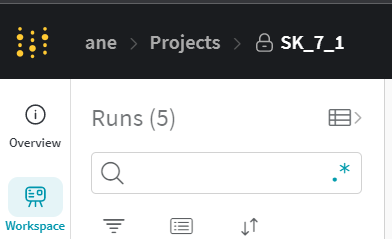

3. Click on filter at top of the table of experiments.
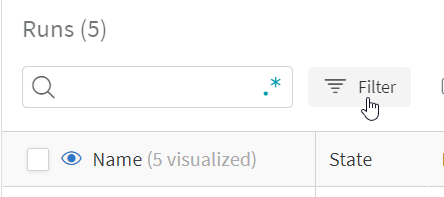
4. A dropdown will show up. Click on `+ Add filter` from the dropdown.
5. You may now filter experiments using any attribute, logged metric, or hyperparameter. In this case, let's see how to filter experiments with `f1` greater than 0.3.
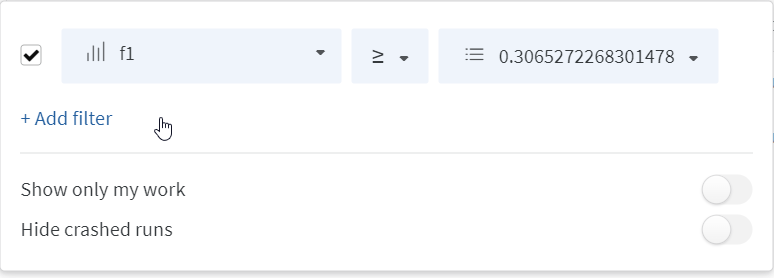